In [ ]:
  from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install prophet
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import numpy as np
import optuna

In [ ]:
# Đọc dữ liệu từ tệp CSV
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/csv/VIC.csv')
# Chuyển đổi cột thời gian thành định dạng datetime
data['Date'] = pd.to_datetime(data['Date'])
# Tạo DataFrame dữ liệu đầu vào
df = pd.DataFrame({'ds': data['Date'], 'y': data['Price']})
df

,ds,y
0,2017-12-01,61653
1,2017-12-04,62893
2,2017-12-05,60331
3,2017-12-06,60331
4,2017-12-07,59504
...,...,...
1371,2023-06-05,52100
1372,2023-06-06,53200
1373,2023-06-07,52800
1374,2023-06-08,52400


In [ ]:
# Chia tập dữ liệu thành train-test-validate theo tỉ lệ
n = len(df)
n_train = int(n * 0.6)
n_test = int(n * 0.3)
n_validate = n - n_train - n_test

train_data = df[:n_train]
test_data = df[n_train:n_train + n_test]
validate_data = df[n_train + n_test:]

In [ ]:
# Hàm mục tiêu để tối ưu hóa
def objective(trial):
    # Xác định không gian tìm kiếm cho siêu tham số
    params = {
        'changepoint_prior_scale': trial.suggest_loguniform('changepoint_prior_scale', 0.01, 10.0),
        'seasonality_prior_scale': trial.suggest_loguniform('seasonality_prior_scale', 0.01, 1.0),
        'holidays_prior_scale': trial.suggest_loguniform('holidays_prior_scale', 0.01, 10.0),
    }

    # Xây dựng mô hình BSTS với siêu tham số hiện tại
    model = Prophet(**params)
    model.fit(train_data)

    # Dự đoán trên tập test
    forecast = model.predict(test_data)

    # Tính toán độ đo RMSE để đánh giá mô hình
    rmse = mean_squared_error(test_data['y'], forecast['yhat'], squared=False)

    return rmse

In [ ]:
# Tìm giá trị tối ưu cho siêu tham số
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=350)

# Lấy giá trị tối ưu cho siêu tham số
best_params = study.best_params

Streaming output truncated to the last 5000 lines.
16:04:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:04:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
[I 2023-06-18 16:04:17,051] Trial 30 finished with value: 45270.07842150777 and parameters: {'changepoint_prior_scale': 0.018733352063298937, 'seasonality_prior_scale': 0.016064243715356873, 'holidays_prior_scale': 0.29792102757456523}. Best is trial 20 with value: 35395.03693994552.
<ipython-input-6-bb80d6b1eb20>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'changepoint_prior_scale': trial.suggest_loguniform('changepoint_prior_scale', 0.01, 10.0),
<ipython-input-6-bb80d6b1eb20>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0

In [ ]:
# Xây dựng mô hình BSTS với siêu tham số tốt nhất
best_model = Prophet(**best_params)
best_model.fit(train_data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqyvcxjgq/bbj17l9q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqyvcxjgq/amllhlst.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61315', 'data', 'file=/tmp/tmpqyvcxjgq/bbj17l9q.json', 'init=/tmp/tmpqyvcxjgq/amllhlst.json', 'output', 'file=/tmp/tmpqyvcxjgq/prophet_modeli4w2t_b8/prophet_model-20230618161126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:11:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:11:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
print("Siêu tham số tối ưu:", best_params)

Siêu tham số tối ưu: {'changepoint_prior_scale': 0.010129349641893319, 'seasonality_prior_scale': 0.01186699752286586, 'holidays_prior_scale': 0.7190458049600658}


In [ ]:
# Dự đoán trên tập test và validate
test_forecast = best_model.predict(test_data)
validate_forecast = best_model.predict(validate_data)

In [ ]:
# Dự đoán 30 ngày tiếp theo
future_dates = pd.date_range(start=df['ds'].max(), periods=30, freq='D')
future_data = pd.DataFrame({'ds': future_dates})

future_forecast = best_model.predict(future_data)

In [ ]:
# In kết quả dự đoán
future_forecast['yhat']

0     134443.253311
1     134032.814480
2     134195.579216
3     134902.159051
4     134939.801125
5     135088.617965
6     135451.145337
7     135579.239687
8     135159.018995
9     135295.762684
10    135960.820643
11    135942.511173
12    136022.312981
13    136304.378278
14    136342.379986
15    135824.398459
16    135857.765026
17    136415.914099
18    136289.225319
19    136261.162435
20    136437.737451
21    136374.314325
22    135760.458747
23    135704.752161
24    136181.622433
25    135982.172982
26    135890.317207
27    136012.246574
28    135903.246255
29    135252.564218
Name: yhat, dtype: float64

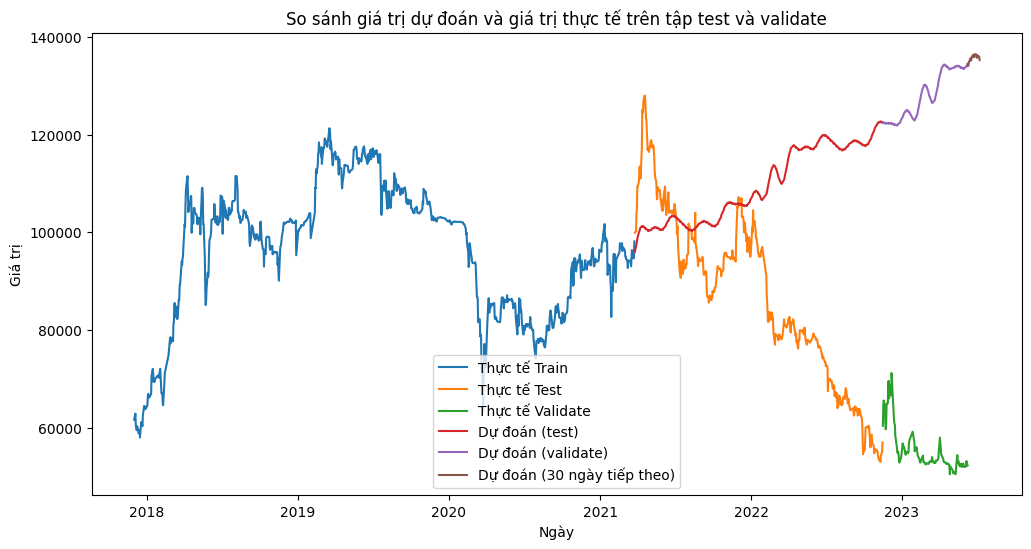

In [ ]:
# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(train_data['ds'], train_data['y'], label='Thực tế Train')
plt.plot(test_data['ds'], test_data['y'], label='Thực tế Test')
plt.plot(validate_data['ds'], validate_data['y'], label='Thực tế Validate')
plt.plot(test_data['ds'], test_forecast['yhat'], label='Dự đoán (test)')
plt.plot(validate_data['ds'], validate_forecast['yhat'], label='Dự đoán (validate)')
plt.plot(future_dates, future_forecast['yhat'], label='Dự đoán (30 ngày tiếp theo)')
plt.xlabel('Ngày')
plt.ylabel('Giá trị')
plt.title('So sánh giá trị dự đoán và giá trị thực tế trên tập test và validate')
plt.legend()
plt.show()

In [ ]:
# Tính toán độ đo RMSE, MAPE, MSE, MAE và R2 cho test data
rmse = np.sqrt(mean_squared_error(test_data['y'], test_forecast['yhat']))
mape = mean_absolute_percentage_error(test_data['y'], test_forecast['yhat'])*100
mse = mean_squared_error(test_data['y'], test_forecast['yhat'])
mae = mean_absolute_error(test_data['y'], test_forecast['yhat'])
r2 = r2_score(test_data['y'], test_forecast['yhat'])

print("RMSE:", rmse)
print("MAPE:", mape)
print("MSE:", mse)
print("MAE:", mae)
print("R2:", r2)

RMSE: 33583.89770517931
MAPE: 37.05350634714682
MSE: 1127878185.0719483
MAE: 26505.61322626268
R2: -2.7711358979911846


In [ ]:
# Tính toán độ đo RMSE, MAPE, MSE, MAE và R2 cho validate data
rmse = np.sqrt(mean_squared_error(validate_data['y'], validate_forecast['yhat']))
mape = mean_absolute_percentage_error(validate_data['y'], validate_forecast['yhat'])*100
mse = mean_squared_error(validate_data['y'], validate_forecast['yhat'])
mae = mean_absolute_error(validate_data['y'], validate_forecast['yhat'])
r2 = r2_score(validate_data['y'], validate_forecast['yhat'])

print("RMSE:", rmse)
print("MAPE:", mape)
print("MSE:", mse)
print("MAE:", mae)
print("R2:", r2)

RMSE: 73061.51584639007
MAPE: 132.68201284604154
MSE: 5337985097.772308
MAE: 72564.38987783877
R2: -247.35007147212926
